In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork, save_model, load_model

from args import *
from utils import *

from tqdm import tqdm
from IPython.display import clear_output as ipyclear

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset

In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

Model training parameters

In [3]:
model_name = "CEAL"
model_network = model_name + "Network"
model_args = args[model_name]

In [4]:
def save_result_data(
    all_args,
    epoch,
    model,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    device,
    optimizer,
    scheduler,
    result_path,
    regression_title="Model Regression",
    save_split=100,
    training=False,
    *args,
    **kwargs
):
    if epoch % save_split != 0 and training is True:
        return

    print("Saving data...")
    save_hyper_parameter(all_args, result_path)
    save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
    test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

    # Reverse normalization of test_out and y
    min, max = get_data_scale(all_args)
    test_y = reverse_min_max_scalar_1d(test_y, min, max)
    test_out = reverse_min_max_scalar_1d(test_out, min, max)
    loss = (test_out.squeeze() - test_y).abs().mean()
    print("MAE loss: ", loss.item())

    # save results
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path,threshold=0.2)
    save_regression_result(test_out, test_y, result_path)
    plot_regression_result(regression_title, result_path, plotfilename="regression_figure.jpeg")

    # save model
    print("Saving model...")
    save_model(result_path, model, epoch, loss, optimizer, scheduler)

    return loss

In [5]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()
# device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
deg = generate_deg(train_dataset).float()
deg = deg.to(device)
model = CEALNetwork(deg, in_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=model_args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode=model_args["sche_mode"], factor=model_args["sche_factor"], patience=model_args["sche_patience"], min_lr=model_args["sche_min_lr"]
)

25092 8364 8363


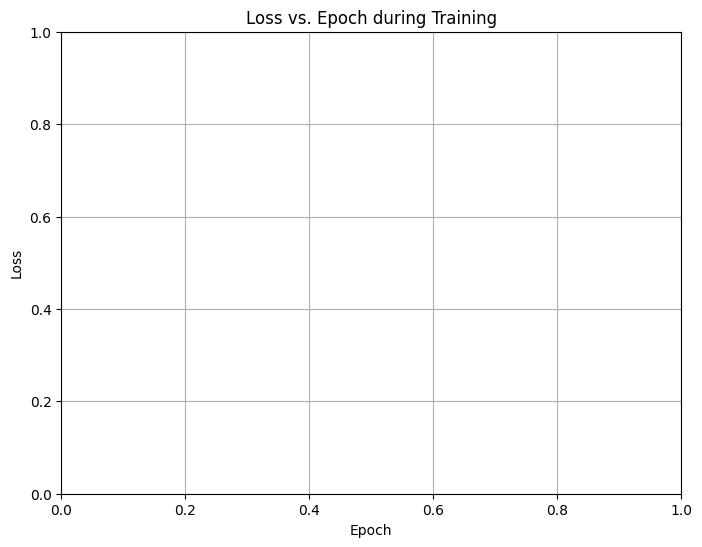

In [6]:
result_path = create_result_folder(osp.join("./results", model_name))
test_best_loss = None
epoch = None

save_split = 100
show_plot_split = 50

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Model training

epoch:49 train:0.0235 valid:0.023 test:0.0223 lr:0.01 best_test:0.0213:   0%|          | 50/10001 [03:12<11:00:42,  3.98s/it] 

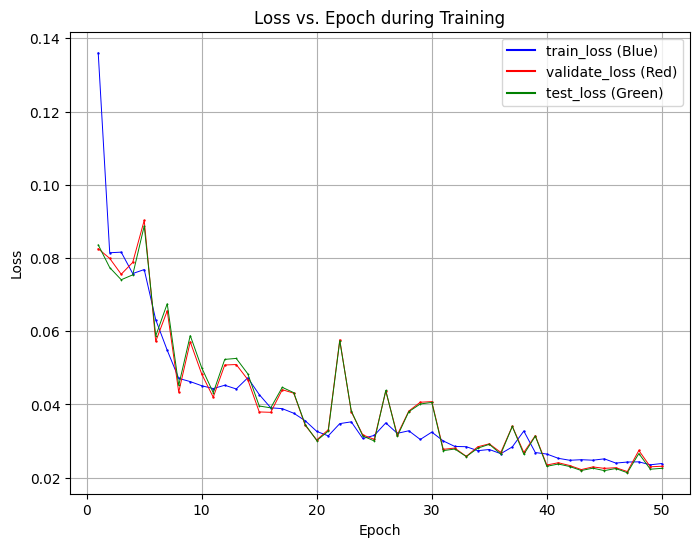

epoch:99 train:0.0203 valid:0.0188 test:0.0181 lr:0.01 best_test:0.0181:   1%|          | 100/10001 [06:28<10:34:19,  3.84s/it]

Saving data...
MAE loss:  0.1767328828573227


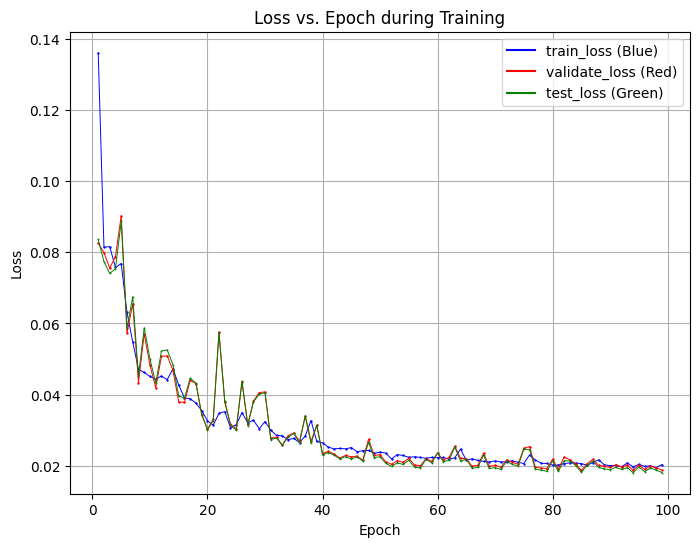

MAE=  0.17673287089822792
Saving model...


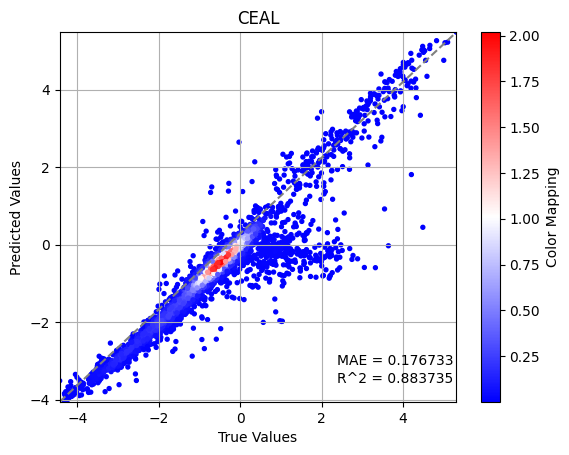

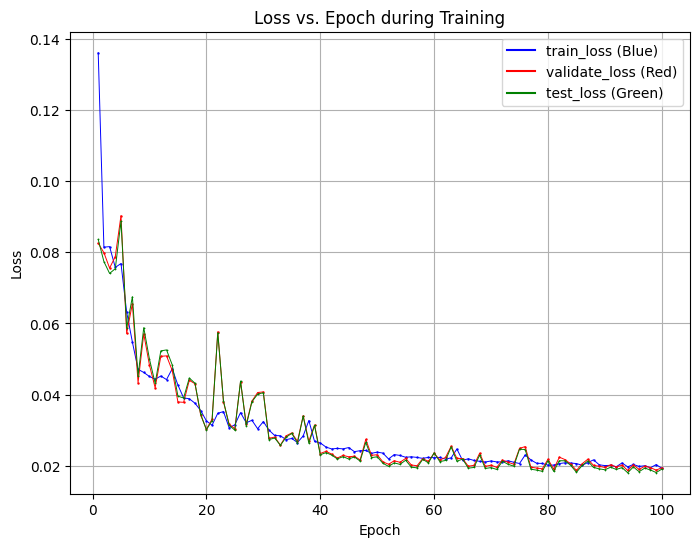

epoch:149 train:0.0181 valid:0.0185 test:0.0178 lr:0.01 best_test:0.017:   1%|▏         | 150/10001 [09:48<10:46:12,  3.94s/it] 

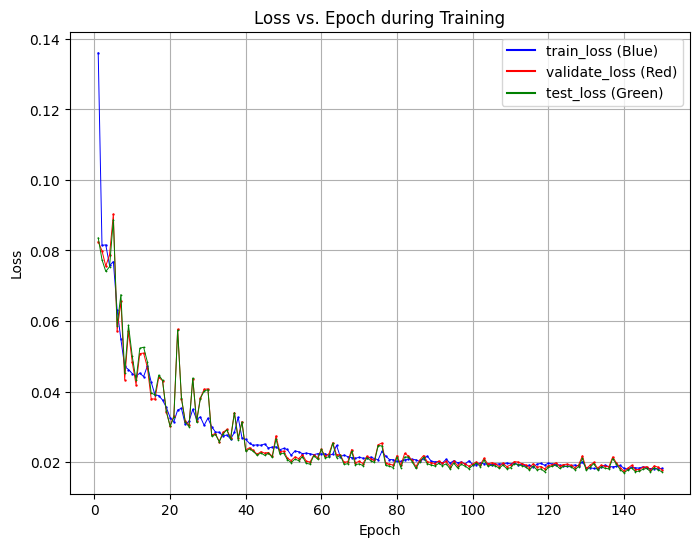

epoch:199 train:0.017 valid:0.0173 test:0.0168 lr:0.01 best_test:0.0162:   2%|▏         | 200/10001 [13:05<10:44:54,  3.95s/it] 

Saving data...
MAE loss:  0.16385871171951294


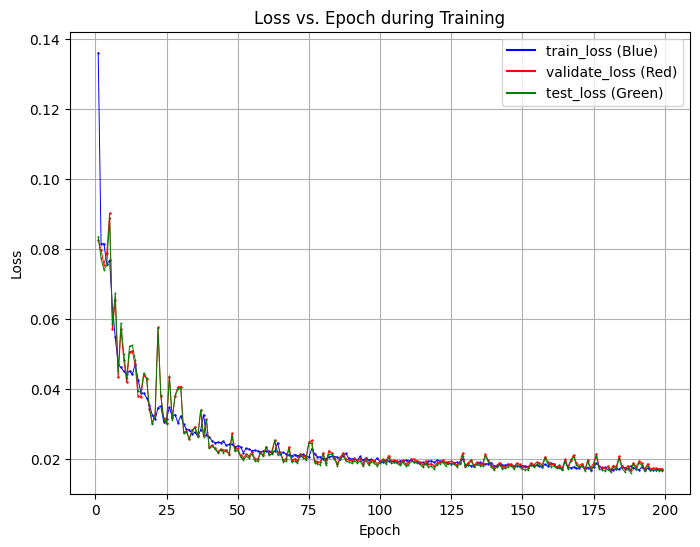

MAE=  0.16385870569829608
Saving model...


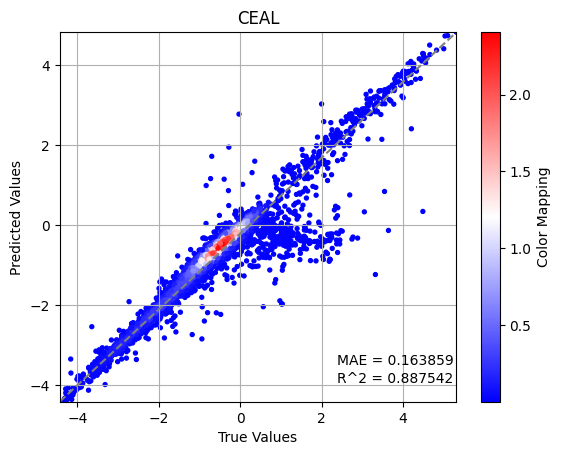

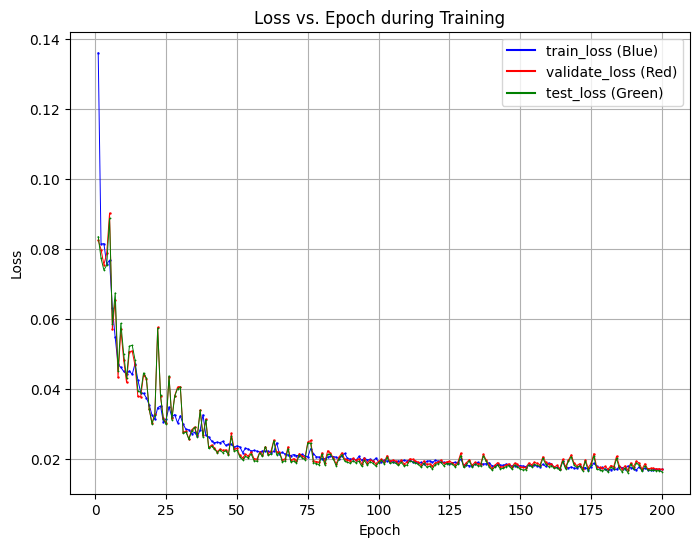

epoch:249 train:0.0159 valid:0.016 test:0.0154 lr:0.01 best_test:0.0154:   2%|▏         | 250/10001 [16:19<10:02:26,  3.71s/it] 

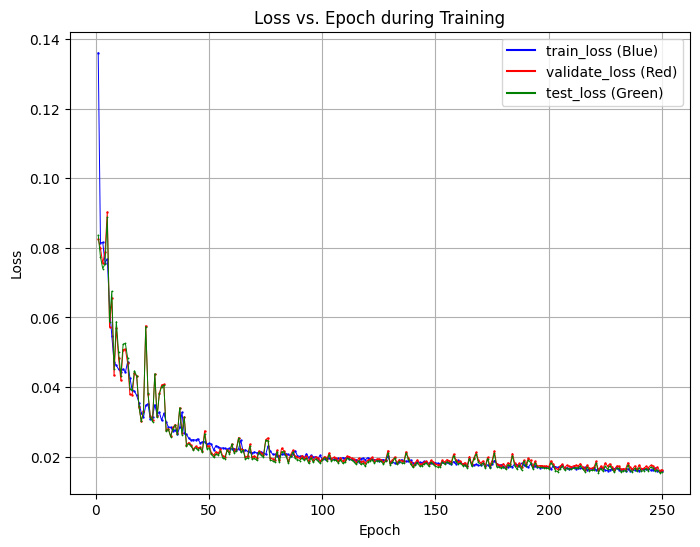

epoch:299 train:0.0154 valid:0.0159 test:0.0155 lr:0.01 best_test:0.0149:   3%|▎         | 300/10001 [20:22<15:17:54,  5.68s/it]

Saving data...
MAE loss:  0.15115825831890106


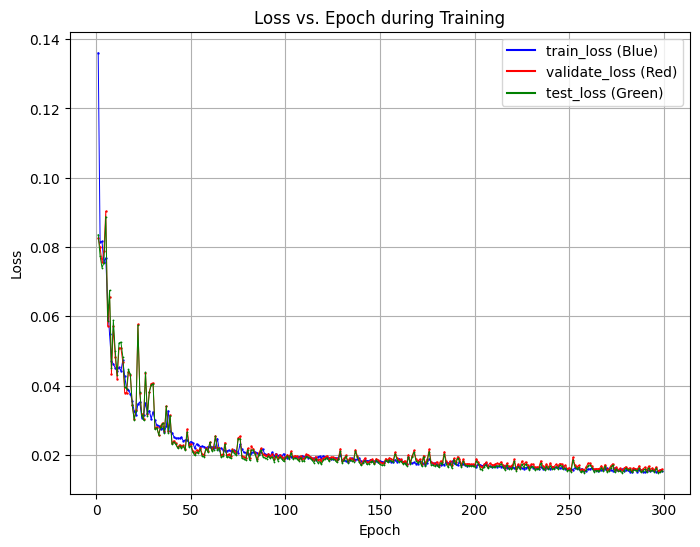

MAE=  0.15115824808512304
Saving model...


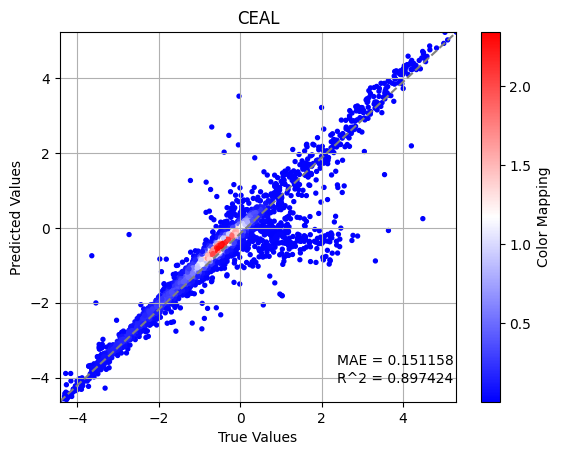

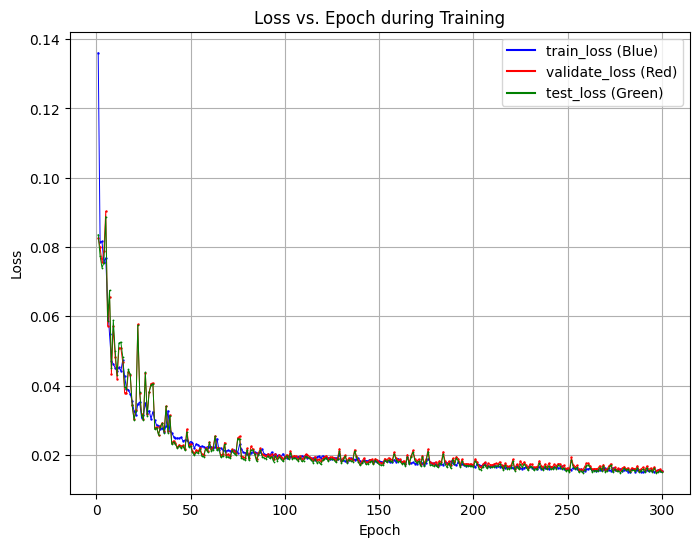

epoch:349 train:0.0144 valid:0.0153 test:0.015 lr:0.01 best_test:0.0143:   3%|▎         | 350/10001 [23:57<10:37:31,  3.96s/it] 

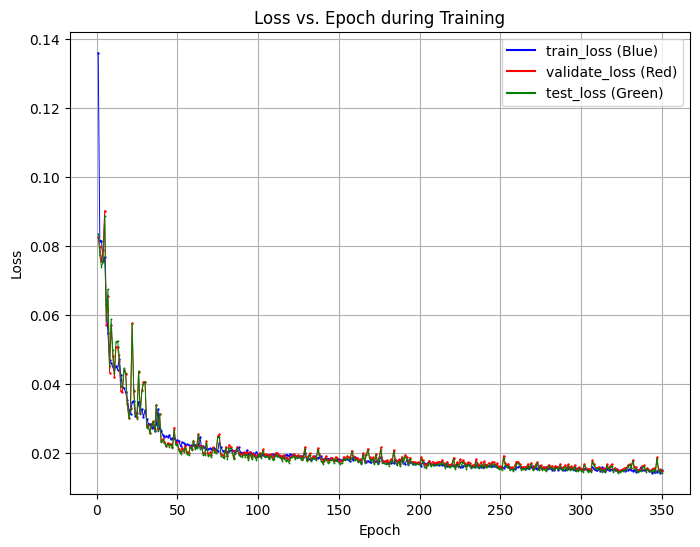

epoch:399 train:0.014 valid:0.0149 test:0.0146 lr:0.01 best_test:0.0141:   4%|▍         | 400/10001 [27:18<10:51:25,  4.07s/it] 

Saving data...
MAE loss:  0.1425921469926834


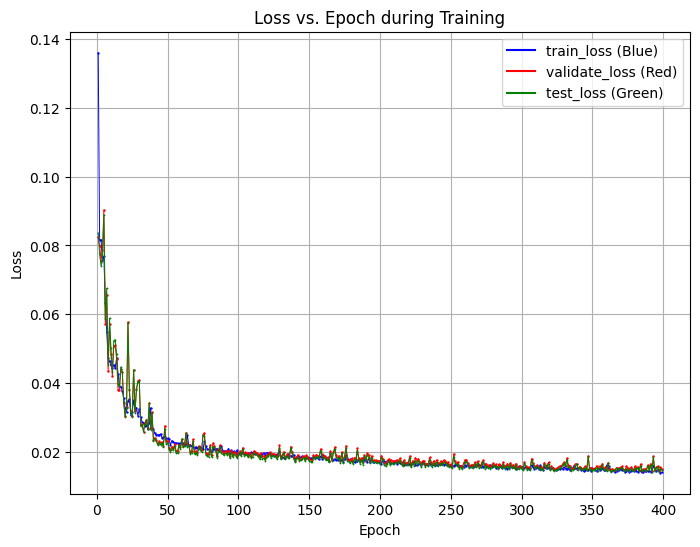

MAE=  0.1425921429481155
Saving model...


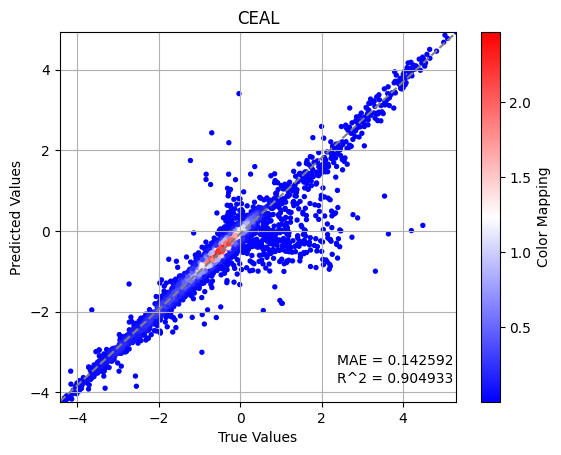

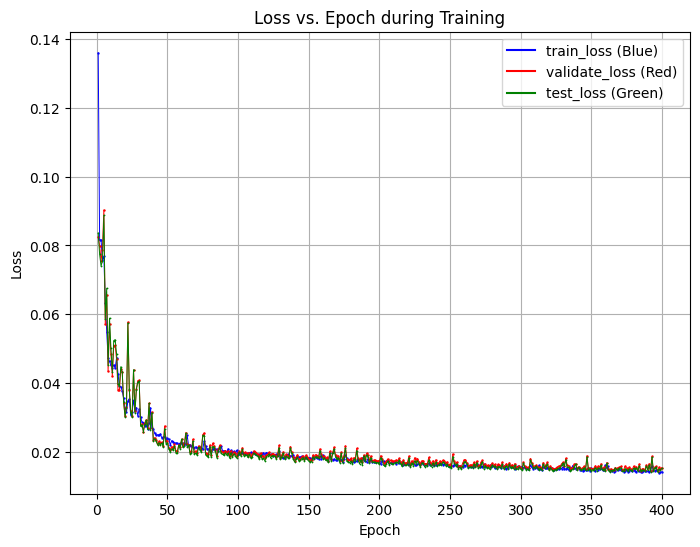

epoch:416 train:0.0139 valid:0.0149 test:0.0146 lr:0.01 best_test:0.0141:   4%|▍         | 417/10001 [28:25<9:58:33,  3.75s/it] 

In [7]:
epoch_start = 0 if epoch is None else epoch
epoch = epoch_start - 1
epochs = model_args["epochs"]

pbar = tqdm(total=(epochs + 1))
pbar.update(epoch_start + 1)

for epoch in range(epoch_start + 1, epochs + 1):

    # auto save and evaluate at every 100 epoch step
    save_result_data(
        args,
        epoch,
        model,
        train_losses,
        val_losses,
        test_losses,
        test_loader,
        test_dataset,
        device,
        optimizer,
        scheduler,
        result_path,
        regression_title=model_name,
        save_split=save_split,
        training=True,
    )

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    torch.cuda.empty_cache()
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    torch.cuda.empty_cache()
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)
    torch.cuda.empty_cache()

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=show_plot_split,threshold=0.2)

    # save best model
    if test_best_loss is None or test_loss < test_best_loss:
        test_best_loss = test_loss
        # save_model_GCN(epoch, model, optimizer, scheduler, result_path)

    progress_msg = (
        "epoch:"
        + str(epoch)
        + " train:"
        + str(round(train_loss, 4))
        + " valid:"
        + str(round(val_loss, 4))
        + " test:"
        + str(round(test_loss, 4))
        + " lr:"
        + str(round(current_lr, 8))
        + " best_test:"
        + str(round(test_best_loss, 4))
    )
    pbar.set_description(progress_msg)
    pbar.update(1)

pbar.close()

Save model, results and checkpoint if need

In [ ]:
save_result_data(
    args,
    epoch,
    model,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    optimizer,
    scheduler,
    device,
    result_path,
    regression_title=model_name,
)

Get test data distribution

In [ ]:
# reverse data scale
min, max = get_data_scale(args)

test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print(loss)

plt.hist(test_y.to("cpu"), range=(-5, 5), bins=50)